<a href="https://colab.research.google.com/github/UrsachiGabriela/PGPU_proiect/blob/main/Optimizari_BFS_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PGPU - proiect


# Generare graf

In [60]:
%%writefile graph_generator.cpp

#include <iostream>
#include <vector>
#include <fstream>
#include <cstdlib>
#include <ctime>
#include <algorithm>

using namespace std;

vector<vector<int>> generateRandomGraph(int numNodes, int numEdges) {
    vector<vector<int>> graph(numNodes);
    srand(time(0));

    for (int i = 0; i < numEdges; ++i) {
        int u = rand() % numNodes;
        int v = rand() % numNodes;

        while (u == v || find(graph[u].begin(), graph[u].end(), v) != graph[u].end()) {
            u = rand() % numNodes;
            v = rand() % numNodes;
        }
        graph[u].push_back(v);
        graph[v].push_back(u);
    }

    return graph;
}

void writeGraphToFile(const string& filename, const vector<vector<int>>& graph) {
    ofstream outputFile(filename);
    if (!outputFile) {
        cerr << "Eroare la deschiderea fisierului pentru scriere!" << endl;
        return;
    }

    for (const auto& neighbors : graph) {
        for (size_t i = 0; i < neighbors.size(); ++i) {
            outputFile << neighbors[i];
            if (i != neighbors.size() - 1) {
                outputFile << " ";
            }
        }
        outputFile << endl;
    }

    outputFile.close();
}

int main() {
    int numNodes = 10000;
    int numEdges = 50000;

    vector<vector<int>> graph = generateRandomGraph(numNodes, numEdges);

    string filename = "graph_output.txt";
    writeGraphToFile(filename, graph);

    cout << "Graf generat si salvat in " << filename << endl;

    return 0;
}



Overwriting graph_generator.cpp


In [61]:
!g++ graph_generator.cpp -o graph_generator
!./graph_generator


Graf generat si salvat in graph_output.txt


In [3]:
from google.colab import files
files.download('graph_output.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# CPU

In [25]:
%%writefile bfs_cpu.cpp

#include <iostream>
#include <vector>
#include <queue>
#include <set>
#include <climits>
#include <fstream>
#include <sstream>
#include <string>
#include <time.h>

using namespace std;

vector<vector<int>> readGraphFromFile(const string& filename) {
    ifstream inputFile(filename);
    if (!inputFile) {
        cerr << "Eroare la deschiderea fisierului!" << endl;
        return {};
    }

    vector<vector<int>> graph;
    string line;

    while (getline(inputFile, line)) {
        stringstream ss(line);
        vector<int> neighbors;
        int neighbor;

        while (ss >> neighbor) {
            neighbors.push_back(neighbor);
        }

        graph.push_back(neighbors);
    }

    inputFile.close();
    return graph;
}



void bfs_cpu(const vector<vector<int>>& adjacencyList, int start_node, vector<int>& distance) {
    queue<int> to_visit_queue;

    fill(distance.begin(), distance.end(), INT_MAX);
    distance[start_node] = 0;

    to_visit_queue.push(start_node);

    while (!to_visit_queue.empty()) {
        int current = to_visit_queue.front();
        to_visit_queue.pop();

        //cout << current <<", distance: " << distance[current] << endl;

        for (int neighbor : adjacencyList[current]) {
            if (distance[neighbor] == INT_MAX) { // neighbor not visited yet
                distance[neighbor] = distance[current] + 1;

                to_visit_queue.push(neighbor);
            }
        }
    }
}

int main() {
    string filename = "graph_output.txt";
    vector<vector<int>> graph = readGraphFromFile(filename);

    //  for (int i = 0; i < graph.size(); ++i) {
    //     cout << "Node " << i << ": ";
    //     for (int neighbor : graph[i]) {
    //         cout << neighbor << " ";
    //     }
    //     cout << endl;
    // }

    vector<vector<int>> graph_small = {
        {1, 2},
        {0, 3, 4},
        {0, 4, 5},
        {1, 6},
        {1, 2, 5},
        {2, 4},
        {3}
    };

    int start_node = 0;
    vector<int> distance;
    distance = vector<int>(graph.size());

    clock_t tCPU;
    tCPU = clock();

    bfs_cpu(graph, start_node, distance);

    tCPU = clock() - tCPU;
    double timeTakenCPU = ((double)tCPU) / CLOCKS_PER_SEC * 1000;
    printf("Graph [10000 nodes]: CPU took %f ms to execute \n", timeTakenCPU);


    int start_node2 = 0;
    vector<int> distance2;
    distance2 = vector<int>(graph_small.size());

    clock_t tCPU2;
    tCPU2 = clock();

    bfs_cpu(graph_small, start_node2, distance2);

    tCPU2 = clock() - tCPU2;
    double timeTakenCPU2 = ((double)tCPU2) / CLOCKS_PER_SEC * 1000;
    printf("Graph [7 nodes]: CPU took %f ms to execute \n", timeTakenCPU2);

    return 0;
}

Overwriting bfs_cpu.cpp


In [26]:
%%shell
g++ bfs_cpu.cpp -o bfs_cpu

In [27]:
%%shell
./bfs_cpu

Graph [10000 nodes]: CPU took 2.804000 ms to execute 
Graph [7 nodes]: CPU took 0.004000 ms to execute 


# GPU

In [62]:
%%writefile bfs2.cu

#include <iostream>
#include <vector>
#include <climits>
#include <cuda_runtime.h>
#include <fstream>
#include <sstream>
#include <string>

using namespace std;


cudaError_t bfs_gpu(const vector<vector<int>> &graph, int start_node, vector<int> &distance);

__global__
void simpleKernel(int level) {
    printf("simple kernel\n");
}


__global__
void computeNextLevel(int *adjacencyList, int *offsets, int *distance, int *currentFrontier, int frontierSize, int *nextFrontier, int *nextFrontierSize, int level) {
    const int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid >= frontierSize) return;

    int currentNode = currentFrontier[tid];
    int start = offsets[currentNode];
    int end = offsets[currentNode + 1];

    for (int i = start; i < end; ++i) {
        int neighbor = adjacencyList[i];

        if (atomicCAS(&distance[neighbor], INT_MAX, level + 1) == INT_MAX) {
            int position = atomicAdd(nextFrontierSize, 1);
            nextFrontier[position] = neighbor;
        }
    }
}

cudaError_t bfs_gpu(const vector<vector<int>> &graph, int start_node, vector<int> &distance) {
    cudaError_t cudaStatus;

    int frontier_size = 1;
    const int NEXT_FRONTIER_SIZE = 0;
    int level = 0;
    int threads_per_block = 1024;

    int num_nodes = graph.size();

    vector<int> adjacencyList;
    vector<int> offsets(num_nodes + 1, 0);

    for (int i = 0; i < num_nodes; ++i) {
        offsets[i + 1] = offsets[i] + graph[i].size();
        adjacencyList.insert(adjacencyList.end(), graph[i].begin(), graph[i].end());
    }

    int *d_adjacencyList = 0;
    int *d_offsets = 0;
    int *d_distance = 0;
    int *d_frontier = 0;
    int *d_nextFrontier = 0;
    int *d_nextFrontierSize = 0;

    cudaStatus = cudaMalloc((void**)&d_adjacencyList, adjacencyList.size() * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_adjacencyList!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_offsets, offsets.size() * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_offsets!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_distance, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_distance!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_frontier, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_frontier!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_nextFrontier, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_nextFrontier!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_nextFrontierSize, sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_nextFrontierSize!");
        goto Error;
    }


    // host to device
    cudaMemcpy(d_adjacencyList, adjacencyList.data(), adjacencyList.size() * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_offsets, offsets.data(), offsets.size() * sizeof(int), cudaMemcpyHostToDevice);

    distance.assign(num_nodes, INT_MAX);
    distance[start_node] = 0;
    cudaMemcpy(d_distance, distance.data(), num_nodes * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_frontier, &start_node, sizeof(int), cudaMemcpyHostToDevice);

    while (frontier_size > 0) {
        cudaMemcpy(d_nextFrontierSize, &NEXT_FRONTIER_SIZE, sizeof(int), cudaMemcpyHostToDevice);

        int *d_currentQueue = (level % 2 == 0) ? d_frontier : d_nextFrontier;
        int *d_nextQueue = (level % 2 == 0) ? d_nextFrontier : d_frontier;

        int blocks = (frontier_size + threads_per_block - 1) / threads_per_block;
        computeNextLevel<<<blocks, threads_per_block>>>(d_adjacencyList, d_offsets, d_distance, d_currentQueue, frontier_size, d_nextQueue, d_nextFrontierSize, level);

        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            cout << "CUDA error: " << err << endl;
            exit(-1);
        }
        cudaDeviceSynchronize();

        cudaMemcpy(&frontier_size, d_nextFrontierSize, sizeof(int), cudaMemcpyDeviceToHost);

        //cout << "Level " << level << ", frontier size: " << frontier_size << endl;

        ++level;
    }

    // device to host
    cudaMemcpy(distance.data(), d_distance, num_nodes * sizeof(int), cudaMemcpyDeviceToHost);

Error:
    cudaFree(d_adjacencyList);
    cudaFree(d_offsets);
    cudaFree(d_distance);
    cudaFree(d_frontier);
    cudaFree(d_nextFrontier);
    cudaFree(d_nextFrontierSize);

    return cudaStatus;
}



vector<vector<int>> readGraphFromFile(const string& filename) {
    ifstream inputFile(filename);
    if (!inputFile) {
        cerr << "Eroare la deschiderea fisierului!" << endl;
        return {};
    }

    vector<vector<int>> graph;
    string line;

    while (getline(inputFile, line)) {
        stringstream ss(line);
        vector<int> neighbors;
        int neighbor;

        while (ss >> neighbor) {
            neighbors.push_back(neighbor);
        }

        graph.push_back(neighbors);
    }

    inputFile.close();
    return graph;
}

int main() {

    // ------------------------Graph [10000 nodes]-------------------------------

    string filename = "graph_output.txt";
    vector<vector<int>> graph = readGraphFromFile(filename);


    int start_node = 0;
    vector<int> distance;

    clock_t tGPU;
    tGPU = clock();

    cudaError_t cudaStatus = bfs_gpu(graph, start_node, distance);

    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "bfs_gpu failed!");
        return 1;
    }

    tGPU = clock() - tGPU;
    double timeTakenGPU = ((double)tGPU) / CLOCKS_PER_SEC * 1000;
    printf("Graph [10000 nodes]: GPU took %f ms to execute \n", timeTakenGPU);

    //for (int i = 0; i < distance.size(); ++i) {
    //    cout << "Node " << i << ", Distance: " << distance[i] << endl;
    //}


    // -------------------------------------------------------------------------


    // ----------------------------Graph [7 nodes]------------------------------
/*
    vector<vector<int>> graph_small = {
        {1, 2},
        {0, 3, 4},
        {0, 4, 5},
        {1, 6},
        {1, 2, 5},
        {2, 4},
        {3}
    };

    int start_node2 = 0;
    vector<int> distance2;

    clock_t tGPU2;
    tGPU2 = clock();

    cudaError_t cudaStatus2 = bfs_gpu(graph_small, start_node2, distance2);


    tGPU2 = clock() - tGPU2;
    double timeTakenGPU2 = ((double)tGPU2) / CLOCKS_PER_SEC * 1000;
    printf("Graph [7 nodes]: GPU took %f ms to execute \n", timeTakenGPU2);

    if (cudaStatus2 != cudaSuccess) {
        fprintf(stderr, "bfs_gpu failed!");
        return 1;
    }

    for (int i = 0; i < distance2.size(); ++i) {
        std::cout << "Node: " << i << ", Distance: " << distance2[i] << std::endl;
    }

*/
    return 0;
}

Overwriting bfs2.cu


That's another big speedup from running multiple blocks!

In [63]:
%%shell

nvcc -Xptxas -v bfs2.cu -o bfs2

nvprof  ./bfs2

#nvprof --print-gpu-trace ./bfs2

#ncu -f --set full -o bfs2 ./bfs2

ptxas info    : 15 bytes gmem
ptxas info    : Compiling entry function '_Z16computeNextLevelPiS_S_S_iS_S_i' for 'sm_52'
ptxas info    : Function properties for _Z16computeNextLevelPiS_S_S_iS_S_i
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 17 registers, 380 bytes cmem[0], 4 bytes cmem[2]
ptxas info    : Compiling entry function '_Z12simpleKerneli' for 'sm_52'
ptxas info    : Function properties for _Z12simpleKerneli
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 8 registers, 324 bytes cmem[0]
==44672== NVPROF is profiling process 44672, command: ./bfs2
Graph [10000 nodes]: GPU took 216.934000 ms to execute 
==44672== Profiling application: ./bfs2
==44672== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   79.32%  268.99us         7  38.426us  10.815us  67.423us  computeNextLevel(int*, int*, int*, int*, int, int*, int*, int)
           

# **Optimizare 1 -- shared memory**

In [64]:
%%writefile bfs_optimized.cu

#include <iostream>
#include <vector>
#include <climits>
#include <cuda_runtime.h>
#include <fstream>
#include <sstream>
#include <string>

using namespace std;


cudaError_t bfs_gpu(const vector<vector<int>> &graph, int start_node, vector<int> &distance);


__global__
void computeNextLevelSharedMemory(int *adjacencyList, int *offsets, int *distance,
                      int *currentFrontier, int frontierSize,
                      int *nextFrontier, int *nextFrontierSize, int level) {

    const int tid = threadIdx.x;
    const int globalTid = blockIdx.x * blockDim.x + threadIdx.x;

    extern __shared__ int sharedFrontier[];

    if (globalTid < frontierSize) {
        sharedFrontier[tid] = currentFrontier[globalTid];
    }
    __syncthreads();

    if (tid < frontierSize) {
        int currentNode = sharedFrontier[tid];
        int start = offsets[currentNode];
        int end = offsets[currentNode + 1];

        for (int i = start; i < end; ++i) {
            int neighbor = adjacencyList[i];

            if (atomicCAS(&distance[neighbor], INT_MAX, level + 1) == INT_MAX) {
                int position = atomicAdd(nextFrontierSize, 1);
                nextFrontier[position] = neighbor;
            }
        }
    }
}


cudaError_t bfs_gpu(const vector<vector<int>> &graph, int start_node, vector<int> &distance) {
    cudaError_t cudaStatus;

    int frontier_size = 1;
    const int NEXT_FRONTIER_SIZE = 0;
    int level = 0;
    int threads_per_block = 1024;

    int num_nodes = graph.size();

    vector<int> adjacencyList;
    vector<int> offsets(num_nodes + 1, 0);

    for (int i = 0; i < num_nodes; ++i) {
        offsets[i + 1] = offsets[i] + graph[i].size();
        adjacencyList.insert(adjacencyList.end(), graph[i].begin(), graph[i].end());
    }

    int *d_adjacencyList = 0;
    int *d_offsets = 0;
    int *d_distance = 0;
    int *d_frontier = 0;
    int *d_nextFrontier = 0;
    int *d_nextFrontierSize = 0;

    cudaStatus = cudaMalloc((void**)&d_adjacencyList, adjacencyList.size() * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_adjacencyList!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_offsets, offsets.size() * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_offsets!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_distance, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_distance!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_frontier, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_frontier!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_nextFrontier, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_nextFrontier!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_nextFrontierSize, sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_nextFrontierSize!");
        goto Error;
    }


    // host to device
    cudaMemcpy(d_adjacencyList, adjacencyList.data(), adjacencyList.size() * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_offsets, offsets.data(), offsets.size() * sizeof(int), cudaMemcpyHostToDevice);

    distance.assign(num_nodes, INT_MAX);
    distance[start_node] = 0;
    cudaMemcpy(d_distance, distance.data(), num_nodes * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_frontier, &start_node, sizeof(int), cudaMemcpyHostToDevice);

    while (frontier_size > 0) {
        cudaMemcpy(d_nextFrontierSize, &NEXT_FRONTIER_SIZE, sizeof(int), cudaMemcpyHostToDevice);

        int *d_currentQueue = (level % 2 == 0) ? d_frontier : d_nextFrontier;
        int *d_nextQueue = (level % 2 == 0) ? d_nextFrontier : d_frontier;

        int blocks = (frontier_size + threads_per_block - 1) / threads_per_block;
        int sharedMemorySize = threads_per_block * sizeof(int);
        computeNextLevelSharedMemory<<<blocks, threads_per_block, sharedMemorySize>>>(d_adjacencyList, d_offsets, d_distance, d_currentQueue, frontier_size, d_nextQueue, d_nextFrontierSize, level);

        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            cout << "CUDA error: " << err << endl;
            exit(-1);
        }
        cudaDeviceSynchronize();

        cudaMemcpy(&frontier_size, d_nextFrontierSize, sizeof(int), cudaMemcpyDeviceToHost);

        //cout << "Level " << level << ", frontier size: " << frontier_size << endl;

        ++level;
    }

    // device to host
    cudaMemcpy(distance.data(), d_distance, num_nodes * sizeof(int), cudaMemcpyDeviceToHost);

Error:
    cudaFree(d_adjacencyList);
    cudaFree(d_offsets);
    cudaFree(d_distance);
    cudaFree(d_frontier);
    cudaFree(d_nextFrontier);
    cudaFree(d_nextFrontierSize);

    return cudaStatus;
}



vector<vector<int>> readGraphFromFile(const string& filename) {
    ifstream inputFile(filename);
    if (!inputFile) {
        cerr << "Eroare la deschiderea fisierului!" << endl;
        return {};
    }

    vector<vector<int>> graph;
    string line;

    while (getline(inputFile, line)) {
        stringstream ss(line);
        vector<int> neighbors;
        int neighbor;

        while (ss >> neighbor) {
            neighbors.push_back(neighbor);
        }

        graph.push_back(neighbors);
    }

    inputFile.close();
    return graph;
}

int main() {

    // ------------------------Graph [10000 nodes]-------------------------------

    string filename = "graph_output.txt";
    vector<vector<int>> graph = readGraphFromFile(filename);


    int start_node = 0;
    vector<int> distance;

    clock_t tGPU;
    tGPU = clock();

    cudaError_t cudaStatus = bfs_gpu(graph, start_node, distance);

    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "bfs_gpu failed!");
        return 1;
    }

    tGPU = clock() - tGPU;
    double timeTakenGPU = ((double)tGPU) / CLOCKS_PER_SEC * 1000;
    printf("Graph [10000 nodes]: GPU took %f ms to execute \n", timeTakenGPU);

    //for (int i = 0; i < distance.size(); ++i) {
    //    cout << "Node " << i << ", Distance: " << distance[i] << endl;
    //}


    // -------------------------------------------------------------------------


    // ----------------------------Graph [7 nodes]------------------------------
/*
    vector<vector<int>> graph_small = {
        {1, 2},
        {0, 3, 4},
        {0, 4, 5},
        {1, 6},
        {1, 2, 5},
        {2, 4},
        {3}
    };

    int start_node2 = 0;
    vector<int> distance2;

    clock_t tGPU2;
    tGPU2 = clock();

    cudaError_t cudaStatus2 = bfs_gpu(graph_small, start_node2, distance2);


    tGPU2 = clock() - tGPU2;
    double timeTakenGPU2 = ((double)tGPU2) / CLOCKS_PER_SEC * 1000;
    printf("Graph [7 nodes]: GPU took %f ms to execute \n", timeTakenGPU2);

    if (cudaStatus2 != cudaSuccess) {
        fprintf(stderr, "bfs_gpu failed!");
        return 1;
    }

    for (int i = 0; i < distance2.size(); ++i) {
        std::cout << "Node: " << i << ", Distance: " << distance2[i] << std::endl;
    }
*/

    return 0;
}

Overwriting bfs_optimized.cu


In [65]:
%%shell

nvcc -Xptxas -v bfs_optimized.cu -o bfs_optimized

nvprof  ./bfs_optimized

#nvprof --print-gpu-trace ./bfs2

#ncu -f --set full -o bfs2 ./bfs2

ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function '_Z28computeNextLevelSharedMemoryPiS_S_S_iS_S_i' for 'sm_52'
ptxas info    : Function properties for _Z28computeNextLevelSharedMemoryPiS_S_S_iS_S_i
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 17 registers, 380 bytes cmem[0], 4 bytes cmem[2]
==44841== NVPROF is profiling process 44841, command: ./bfs_optimized
Graph [10000 nodes]: GPU took 218.223000 ms to execute 
==44841== Profiling application: ./bfs_optimized
==44841== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   77.74%  241.54us         7  34.505us  9.1200us  63.039us  computeNextLevelSharedMemory(int*, int*, int*, int*, int, int*, int*, int)
                   16.82%  52.254us        11  4.7500us     639ns  35.455us  [CUDA memcpy HtoD]
                    5.44%  16.896us         8  2.1120us  1.6320us  4.5120us  [CUDA memcpy DtoH]
      API calls:

# **Optimizare 2**

In [66]:
%%writefile bfs_optim.cu

#include <iostream>
#include <vector>
#include <climits>
#include <cuda_runtime.h>
#include <fstream>
#include <sstream>
#include <string>

using namespace std;


cudaError_t bfs_gpu(const vector<vector<int>> &graph, int start_node, vector<int> &distance);


__global__
void computeNextLayer(int n, int *adjacencyList, int *offsets, int *distance, int level, bool *done) {
    const int tid = blockIdx.x * blockDim.x + threadIdx.x;

    if (tid < n) {
        if (distance[tid] == level) {
            int start = offsets[tid];
            int end = offsets[tid + 1];
            for (int i = start; i < end; ++i) {
                int neighbor = adjacencyList[i];
                if (atomicCAS(&distance[neighbor], INT_MAX, level + 1) == INT_MAX) {
                  *done = false;
                }
            }
        }
    }
}

cudaError_t bfs_gpu(const vector<vector<int>> &graph, int start_node, vector<int> &distance) {
    cudaError_t cudaStatus;

    int num_nodes = graph.size();

    bool done = false;
    const bool true_value = true;
    int level = 0;
    int N_THREADS_PER_BLOCK = 1024;

    vector<int> adjacencyList;
    vector<int> offsets(num_nodes + 1, 0);

    for (int i = 0; i < num_nodes; ++i) {
        offsets[i + 1] = offsets[i] + graph[i].size();
        adjacencyList.insert(adjacencyList.end(), graph[i].begin(), graph[i].end());
    }

    int *d_adjacencyList = 0;
    int *d_offsets = 0;
    int *d_distance = 0;
    bool *d_done = 0;

    cudaStatus = cudaMalloc((void**)&d_adjacencyList, adjacencyList.size() * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_adjacencyList!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_offsets, offsets.size() * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_offsets!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_distance, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_distance!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_done, sizeof(bool));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_done!");
        goto Error;
    }

    // host to device
    cudaMemcpy(d_adjacencyList, adjacencyList.data(), adjacencyList.size() * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_offsets, offsets.data(), offsets.size() * sizeof(int), cudaMemcpyHostToDevice);

    distance.assign(num_nodes, INT_MAX);
    distance[start_node] = 0;
    cudaMemcpy(d_distance, distance.data(), num_nodes * sizeof(int), cudaMemcpyHostToDevice);


    while (!done) {
        done = true;
        cudaMemcpy(d_done, &true_value, sizeof(bool), cudaMemcpyHostToDevice);

        int blocks = (num_nodes + N_THREADS_PER_BLOCK - 1) / N_THREADS_PER_BLOCK;
        computeNextLayer<<<blocks, N_THREADS_PER_BLOCK>>>(num_nodes, d_adjacencyList, d_offsets, d_distance, level, d_done);

        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            cout << "CUDA error: " << err << endl;
            exit(-1);
        }

        cudaDeviceSynchronize();
        cudaMemcpy(&done, d_done, sizeof(bool), cudaMemcpyDeviceToHost);
        ++level;
    }


    // device to host
    cudaMemcpy(distance.data(), d_distance, num_nodes * sizeof(int), cudaMemcpyDeviceToHost);

Error:
    cudaFree(d_adjacencyList);
    cudaFree(d_offsets);
    cudaFree(d_distance);
    cudaFree(d_done);

    return cudaStatus;
}



vector<vector<int>> readGraphFromFile(const string& filename) {
    ifstream inputFile(filename);
    if (!inputFile) {
        cerr << "Eroare la deschiderea fisierului!" << endl;
        return {};
    }

    vector<vector<int>> graph;
    string line;

    while (getline(inputFile, line)) {
        stringstream ss(line);
        vector<int> neighbors;
        int neighbor;

        while (ss >> neighbor) {
            neighbors.push_back(neighbor);
        }

        graph.push_back(neighbors);
    }

    inputFile.close();
    return graph;
}

int main() {

    // ------------------------Graph [10000 nodes]-------------------------------

    string filename = "graph_output.txt";
    vector<vector<int>> graph = readGraphFromFile(filename);


    int start_node = 0;
    vector<int> distance;

    clock_t tGPU;
    tGPU = clock();

    cudaError_t cudaStatus = bfs_gpu(graph, start_node, distance);

    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "bfs_gpu failed!");
        return 1;
    }

    tGPU = clock() - tGPU;
    double timeTakenGPU = ((double)tGPU) / CLOCKS_PER_SEC * 1000;
    printf("Graph [10000 nodes]: GPU took %f ms to execute \n", timeTakenGPU);

    //for (int i = 0; i < distance.size(); ++i) {
    //    cout << "Node " << i << ", Distance: " << distance[i] << endl;
    //}


    // -------------------------------------------------------------------------


    // ----------------------------Graph [7 nodes]------------------------------
/*
    vector<vector<int>> graph_small = {
        {1, 2},
        {0, 3, 4},
        {0, 4, 5},
        {1, 6},
        {1, 2, 5},
        {2, 4},
        {3}
    };


    int start_node2 = 0;
    vector<int> distance2;

    clock_t tGPU2;
    tGPU2 = clock();

    cudaError_t cudaStatus2 = bfs_gpu(graph_small, start_node2, distance2);


    tGPU2 = clock() - tGPU2;
    double timeTakenGPU2 = ((double)tGPU2) / CLOCKS_PER_SEC * 1000;
    printf("Graph [7 nodes]: GPU took %f ms to execute \n", timeTakenGPU2);

    if (cudaStatus2 != cudaSuccess) {
        fprintf(stderr, "bfs_gpu failed!");
        return 1;
    }

    for (int i = 0; i < distance2.size(); ++i) {
        cout << "Node " << i << ", Distance: " << distance2[i] << endl;
    }
*/


    return 0;
}

Overwriting bfs_optim.cu


In [67]:
%%shell

nvcc -Xptxas -v bfs_optim.cu -o bfs_optim

nvprof  ./bfs_optim

ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function '_Z16computeNextLayeriPiS_S_iPb' for 'sm_52'
ptxas info    : Function properties for _Z16computeNextLayeriPiS_S_iPb
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 16 registers, 368 bytes cmem[0], 4 bytes cmem[2]
==44979== NVPROF is profiling process 44979, command: ./bfs_optim
Graph [10000 nodes]: GPU took 219.998000 ms to execute 
==44979== Profiling application: ./bfs_optim
==44979== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   62.10%  112.07us         7  16.009us  6.5600us  27.392us  computeNextLayer(int, int*, int*, int*, int, bool*)
                   28.37%  51.200us        10  5.1200us     640ns  35.327us  [CUDA memcpy HtoD]
                    9.52%  17.185us         8  2.1480us  1.6640us  4.5120us  [CUDA memcpy DtoH]
      API calls:   99.46%  188.45ms         4  47.112ms  2.8260us  188.43ms  cu

# **Scalabilitatea solutiei**

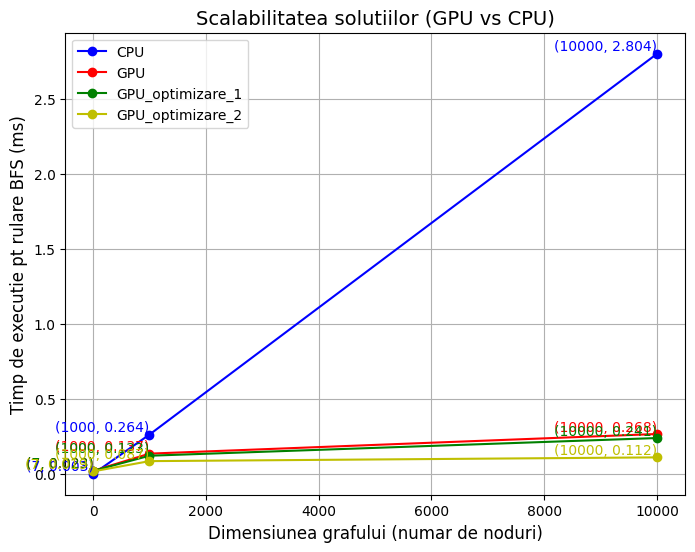

In [2]:
import matplotlib.pyplot as plt


nodes = [7, 1000, 10000]

cpu_times = [0.003, 0.264, 2.804]
gpu_times = [0.023, 0.137, 0.268]
gpu_times_shared_mem = [0.023, 0.123, 0.241]
gpu_times_optim_2 = [0.019, 0.087, 0.112]


plt.figure(figsize=(8,6))
plt.plot(nodes, cpu_times, label='CPU', marker='o', color='b')
plt.plot(nodes, gpu_times, label='GPU', marker='o', color='r')
plt.plot(nodes, gpu_times_shared_mem, label='GPU_optimizare_1', marker='o', color='g')
plt.plot(nodes, gpu_times_optim_2, label='GPU_optimizare_2', marker='o', color='y')


for x, y in zip(nodes, cpu_times):
    plt.text(x, y, f'({x}, {y:.3f})', fontsize=10, ha='right', va='bottom', color='b')
for x, y in zip(nodes, gpu_times):
    plt.text(x, y, f'({x}, {y:.3f})', fontsize=10, ha='right', va='bottom', color='r')
for x, y in zip(nodes, gpu_times_shared_mem):
    plt.text(x, y, f'({x}, {y:.3f})', fontsize=10, ha='right', va='bottom', color='g')
for x, y in zip(nodes, gpu_times_optim_2):
    plt.text(x, y, f'({x}, {y:.3f})', fontsize=10, ha='right', va='bottom', color='y')

plt.xlabel('Dimensiunea grafului (numar de noduri)', fontsize=12)
plt.ylabel('Timp de executie pt rulare BFS (ms)', fontsize=12)
plt.title('Scalabilitatea solutiilor (GPU vs CPU)', fontsize=14)


plt.legend()


plt.grid(True)
plt.show()


# **Calcul occupancy**

In [ ]:
!pip install pycuda

import pycuda.driver as cuda
import pycuda.autoinit

def calculate_occupancy():

    device = cuda.Device(0)
    device_name = device.name()
    compute_capability = device.compute_capability()
    max_threads_per_block = device.max_threads_per_block
    warp_size = device.warp_size
    max_threads_per_multiprocessor = device.max_threads_per_multiprocessor
    max_registers_per_multiprocessor = device.max_registers_per_multiprocessor


    attributes = device.get_attributes()
    shared_memory_per_multiprocessor = attributes[cuda.device_attribute.MAX_SHARED_MEMORY_PER_MULTIPROCESSOR]

    # Kernel-specific details
    threads_per_block = 256
    registers_per_thread = 17
    shared_memory_per_block = 0


    warps_per_block = threads_per_block // warp_size
    max_warps_per_multiprocessor = max_threads_per_multiprocessor // warp_size

    active_warps_due_to_threads = max_threads_per_multiprocessor // threads_per_block
    active_warps_due_to_registers = max_registers_per_multiprocessor // (registers_per_thread * warp_size)
    active_warps_due_to_shared_memory = (
        shared_memory_per_multiprocessor // shared_memory_per_block
        if shared_memory_per_block > 0
        else max_warps_per_multiprocessor
    )

    active_warps_per_multiprocessor = min(
        active_warps_due_to_threads,
        active_warps_due_to_registers,
        active_warps_due_to_shared_memory,
        max_warps_per_multiprocessor,
    )


    occupancy = (active_warps_per_multiprocessor / max_warps_per_multiprocessor) * 100


    print(f"Device: {device_name}")
    print(f"Compute Capability: {compute_capability[0]}.{compute_capability[1]}")
    print(f"Max Threads per Block: {max_threads_per_block}")
    print(f"Max Warps per Multiprocessor: {max_warps_per_multiprocessor}")
    print(f"Active Warps per Multiprocessor: {active_warps_per_multiprocessor}")
    print(f"Theoretical Occupancy: {occupancy:.2f}%")

if __name__ == "__main__":
    calculate_occupancy()



Device: Tesla T4
Compute Capability: 7.5
Max Threads per Block: 1024
Max Warps per Multiprocessor: 32
Active Warps per Multiprocessor: 4
Theoretical Occupancy: 12.50%
